In [82]:
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## Part1:数据观察

In [83]:
#忽略部分版本警告
warnings.filterwarnings('ignore')
#设置sns样式
sns.set(style='white',context='notebook',palette='muted')
#导入数据
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

In [84]:
#合并数据集
full = train.append(test, ignore_index=True)
full.describe()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


#### Point1:不同港口对生存率的影响

In [85]:
# 计算不同类型embarked的乘客，其生存率为多少
# S:南安普顿港southampton;
# Q:皇后镇 Queentown;
# C:瑟堡 Cherbourg
print('Embarked为"S"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'S'].value_counts(normalize=True)[1])
print('Embarked为"C"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'C'].value_counts(normalize=True)[1])
print('Embarked为"Q"的乘客，其生存率为%.2f' % full['Survived'][full['Embarked'] == 'Q'].value_counts(normalize=True)[1])

Embarked为"S"的乘客，其生存率为0.34
Embarked为"C"的乘客，其生存率为0.55
Embarked为"Q"的乘客，其生存率为0.39


#### Point2:观察乘客同行的父母以及子女的数量对生存率的影响

<Axes: xlabel='Parch', ylabel='Survived'>

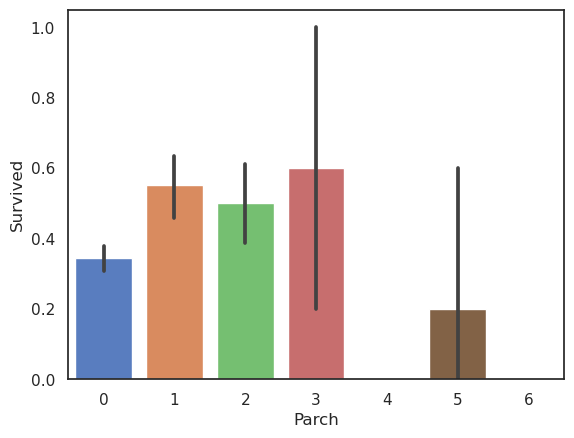

In [86]:
sns.barplot(data=train,x='Parch',y='Survived')

#### Point3:乘客同行的同辈数量与生存率之间的关系

<Axes: xlabel='SibSp', ylabel='Survived'>

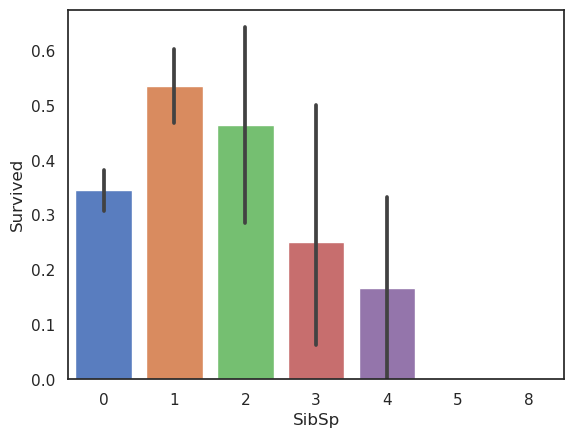

In [87]:
# SibSp与Survived：当乘客同行的同辈数量适中时生存率较高
sns.barplot(data=train, x='SibSp', y='Survived')

#### Point4:乘客客舱与生存率的关系

<Axes: xlabel='Pclass', ylabel='Survived'>

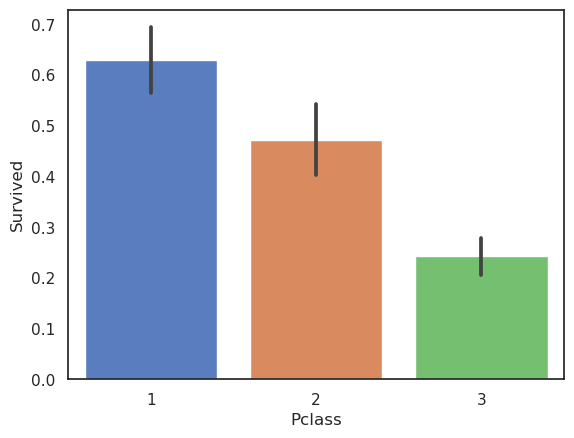

In [88]:
# Pclass与Survived：乘客客舱等级越高，生存率越高
sns.barplot(data=train, x='Pclass', y='Survived')

#### Point5:性别对生存率的影响

<Axes: xlabel='Sex', ylabel='Survived'>

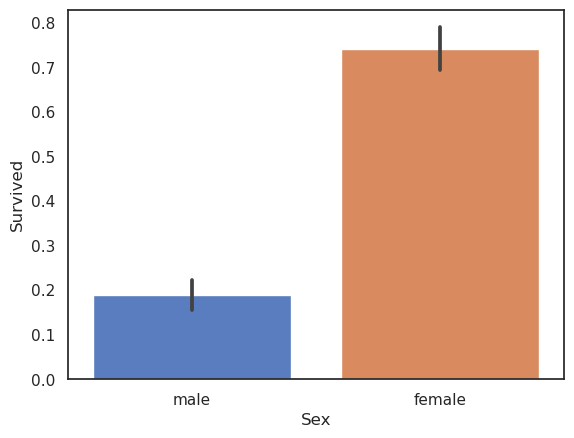

In [89]:
# Sex与Survived：女性的生存率远高于男性
sns.barplot(data=train, x='Sex', y='Survived')

#### Point6:年龄对生存率的影响

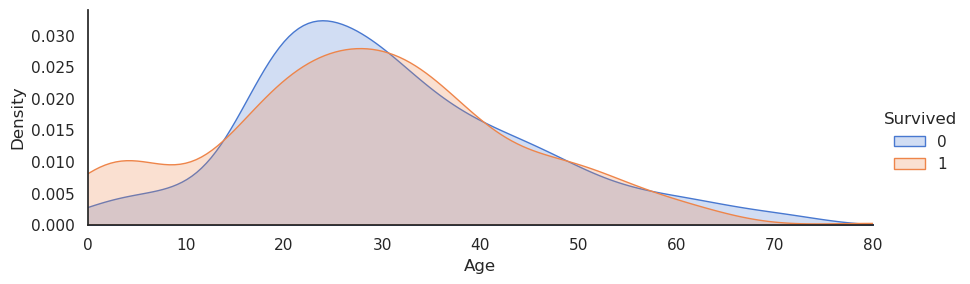

In [90]:
ageFacet = sns.FacetGrid(train, hue='Survived', aspect=3)    # 创建坐标轴
ageFacet.map(sns.kdeplot, 'Age', shade=True)                 # 作图，选择图形类型
ageFacet.set(xlim=(0, train['Age'].max()))                   # 其他信息：坐标轴范围、标签等
ageFacet.add_legend()

#### Point7:票价对生存率的影响

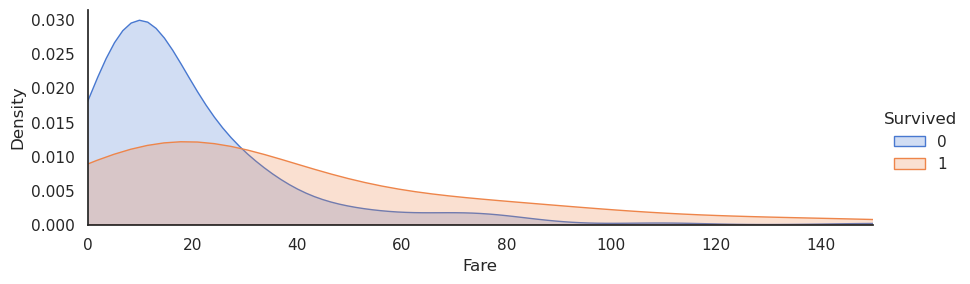

In [91]:
ageFacet = sns.FacetGrid(train, hue='Survived', aspect=3)        # 创建坐标轴
ageFacet.map(sns.kdeplot, 'Fare', shade=True)
ageFacet.set(xlim=(0, 150))
ageFacet.add_legend()

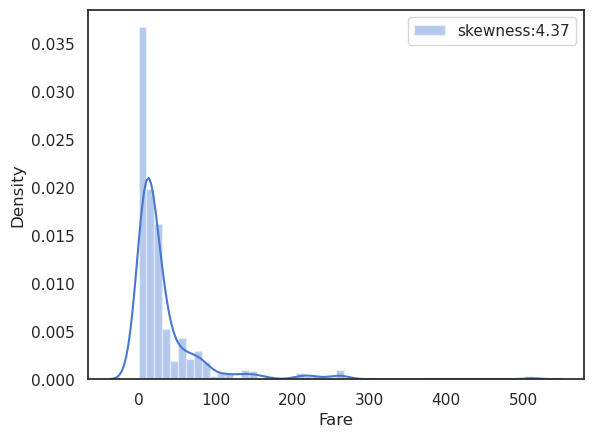

In [92]:
#查看票价fare的分布
farePlot = sns.distplot(full['Fare'][full['Fare'].notnull()], label='skewness:%.2f' % (full['Fare'].skew()))
farePlot.legend(loc='best')

## Part2:数据预处理

In [93]:
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc 
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold

In [94]:
#忽略部分版本警告
warnings.filterwarnings('ignore')
#设置sns样式
sns.set(style='white',context='notebook',palette='muted')
#导入数据
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
full = train.append(test, ignore_index=True)

#### Point1:对Cabin船舱标签进行缺失值填充

In [95]:
#对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
full['Cabin']=full['Cabin'].fillna('U')
full['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

#### Point2:对Embarked登船港口进行缺失值处理

In [96]:
full[full['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [97]:
#查看Embarked数据分布情况
full['Embarked']=full['Embarked'].fillna('S')
full['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

#### Point3:对fare票价进行缺失值处理

In [98]:
# 利用3等舱，登船港口为英国，舱位未知旅客的平均票价来填充缺失值。
full['Fare']=full['Fare'].fillna(full[(full['Pclass']==3)&(full['Embarked']=='S')&(full['Cabin']=='U')]['Fare'].mean())

## Part3:特征工程 ##

#### Point1:头衔信息提取

In [99]:
#构造新特征Title
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
#查看title数据分布
full['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [100]:
# 将相近的特征整合在一起
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'
 
full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

#### Point2:FamilyNum及FamilySize信息提取

<Axes: xlabel='familyNum', ylabel='Survived'>

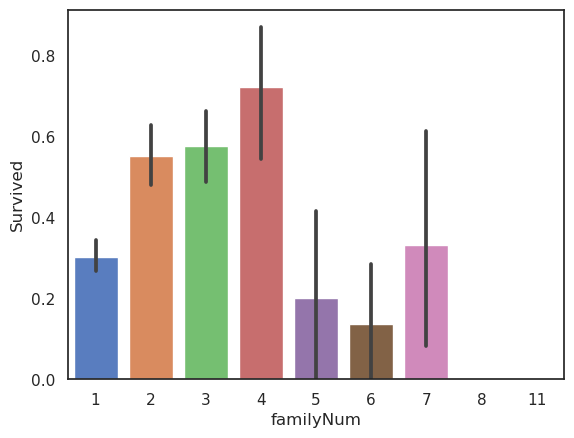

In [101]:
full['familyNum']=full['Parch']+full['SibSp']+1
# 查看familyNum与Survived
sns.barplot(data=full,x='familyNum',y='Survived')

<Axes: xlabel='familySize', ylabel='Survived'>

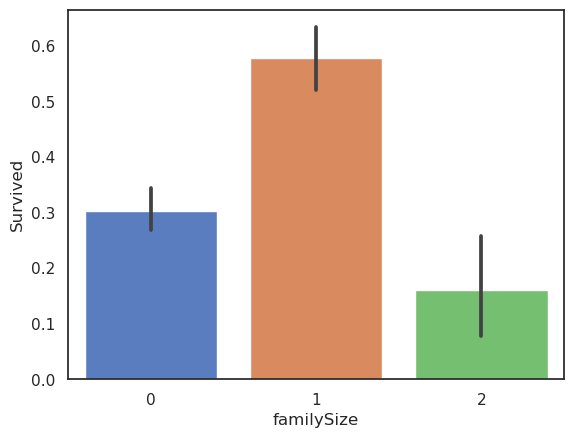

In [102]:
# 按照家庭成员人数多少，将家庭规模分为“小、中、大”三类：
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2
 
full['familySize']=full['familyNum'].map(familysize)
full['familySize'].value_counts()
# 查看familySize与Survived
sns.barplot(data=full,x='familySize',y='Survived')
# 当家庭规模适中时，乘客的生存率更高。

#### Point3:共票号乘客数量TickCot以及TickGroup

In [103]:
# 同一票号的乘客数量可能不同，可能也与乘客生存率有关系。
# 提取各票号的乘客数量
TickCountDict={}
TickCountDict=full['Ticket'].value_counts()
TickCountDict.head()

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
Name: Ticket, dtype: int64

In [104]:
#将同票号乘客数量数据并入数据集中
full['TickCot']=full['Ticket'].map(TickCountDict)
full['TickCot'].head()

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64

<Axes: xlabel='TickCot', ylabel='Survived'>

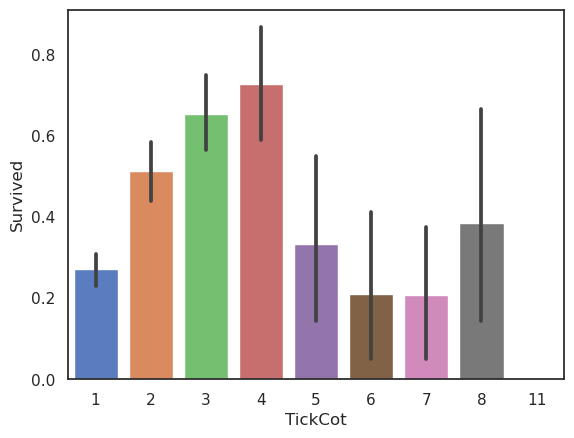

In [105]:
# 查看TickCot与Survived之间关系
sns.barplot(data=full,x='TickCot',y='Survived')
# 当TickCot大小适中时，乘客生存率较高。

<Axes: xlabel='TickGroup', ylabel='Survived'>

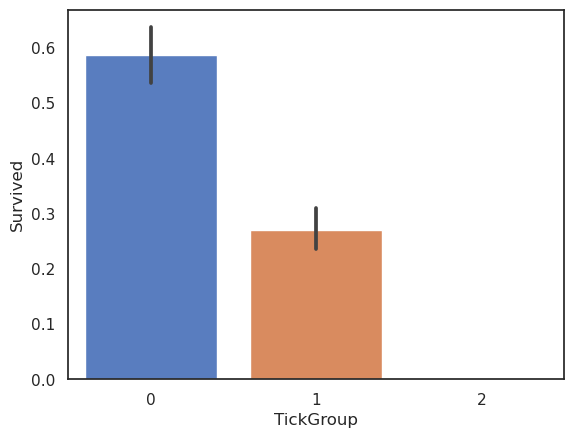

In [106]:
#按照TickCot大小，将TickGroup分为三类。
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else :
        return 2
#得到各位乘客TickGroup的类别
full['TickGroup']=full['TickCot'].map(TickCountGroup)
#查看TickGroup与Survived之间关系
sns.barplot(data=full,x='TickGroup',y='Survived')

#### Point4:Cabin客舱类型信息Deck

<Axes: xlabel='Deck', ylabel='Survived'>

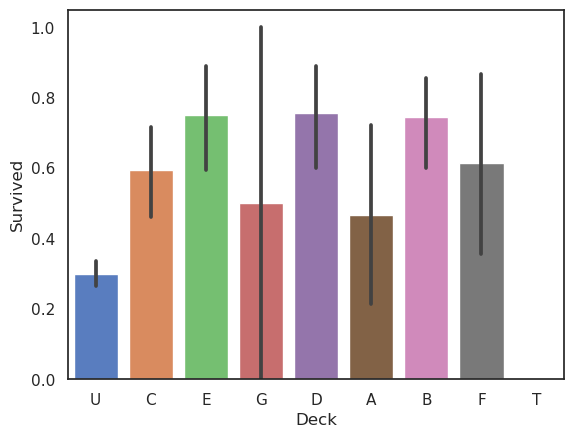

In [107]:
#提取Cabin字段首字母
full['Deck']=full['Cabin'].map(lambda x:x[0])
#查看不同Deck类型乘客的生存率
sns.barplot(data=full,x='Deck',y='Survived')
# 当乘客的客舱类型为B/D/E时，生存率较高；当客舱类型为U/T时，生存率较低。

#### Point5:Age缺失值信息填充：构建随机森林模型预测缺失的数据

In [108]:
full[full['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,familyNum,familySize,TickCot,TickGroup,Deck
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,U,Q,Mr,1,0,1,1,U
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,U,S,Mr,1,0,1,1,U
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,U,C,Mrs,1,0,1,1,U
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,U,C,Mr,1,0,1,1,U
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,U,Q,Miss,1,0,1,1,U


#### Point6:筛选数据

In [109]:
#筛选数据集
AgePre=full[['Age','Parch','Pclass','SibSp','Title','familyNum','Ticket']]
#进行one-hot编码
AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')
#查看变量间相关性
AgeCorrDf=pd.DataFrame()
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()

Pclass                    -0.408106
Title_Master              -0.385380
Title_Miss                -0.282977
SibSp                     -0.243699
familyNum                 -0.240229
                             ...   
Ticket_SOTON/OQ 3101316         NaN
Ticket_SOTON/OQ 392082          NaN
Ticket_SOTON/OQ 392086          NaN
Ticket_W./C. 6607               NaN
Ticket_W./C. 6609               NaN
Name: Age, Length: 940, dtype: float64

In [110]:
AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)
AgePre.head()

,Age,Parch,Pclass,SibSp,familyNum,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


#### Point7:拆分数据并建立模型（利用随机森林构建模型）

In [111]:
#拆分实验集和预测集
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnKnown=AgePre[AgePre['Age'].isnull()]
 
#生成实验数据的特征和标签
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']
#生成预测数据的特征
AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)
 
#利用随机森林构建模型
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

#### Point8:利用模型进行预测并且填入原来的数据集中

In [112]:
#预测年龄
AgeUnKnown_y=rfr.predict(AgeUnKnown_X)
#填充预测数据
full.loc[full['Age'].isnull(),['Age']]=AgeUnKnown_y
full.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  familyNum    1309 non-null   int64  
 14  familySize   1309 non-null   int64  
 15  TickCot      1309 non-null   int64  
 16  TickGroup    1309 non-null   int64  
 17  Deck         1309 non-null   object 
dtypes: float64(3), int64(8), object(7)
memory usage:

## Part4:同组识别

#### 12岁以上的男性：找出男性中同姓氏并且获救的部分

In [113]:
#提取乘客的姓氏及相应的乘客数
full['Surname']=full['Name'].map(lambda x:x.split(',')[0].strip())
SurNameDict={}
SurNameDict=full['Surname'].value_counts()
full['SurnameNum']=full['Surname'].map(SurNameDict)
 
#将数据分为两组
MaleDf=full[(full['Sex']=='male')&(full['Age']>12)&(full['familyNum']>=2)]
FemChildDf=full[((full['Sex']=='female')|(full['Age']<=12))&(full['familyNum']>=2)]
 
MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
MSurNamDf.value_counts()

0.0    89
1.0    19
0.5     3
Name: Survived, dtype: int64

In [114]:
MSurNamDict={}
MSurNamDict=MSurNamDf[MSurNamDf.values==1].index
MSurNamDict

Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname')

#### 女性以及年龄在12岁以下的儿童：找出女性以及儿童中同姓氏均遇难的部分

In [115]:
#分析女性及儿童同组效应
FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
FCSurNamDf.value_counts()

1.000000    115
0.000000     27
0.750000      2
0.333333      1
0.142857      1
Name: Survived, dtype: int64

In [116]:
#获得生存率为0的姓氏
FCSurNamDict={}
FCSurNamDict=FCSurNamDf[FCSurNamDf.values==0].index
FCSurNamDict

Index(['Ahlin', 'Arnold-Franchi', 'Barbara', 'Boulos', 'Bourke', 'Caram',
       'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Johnston', 'Jussila',
       'Lahtinen', 'Lefebre', 'Lobb', 'Palsson', 'Panula', 'Rice', 'Robins',
       'Rosblom', 'Sage', 'Skoog', 'Strom', 'Turpin', 'Van Impe',
       'Vander Planke', 'Zabour'],
      dtype='object', name='Surname')

In [117]:
#对数据集中这些姓氏的男性数据进行修正：1、性别改为女；2、年龄改为5。
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Age']=5
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(MSurNamDict))&(full['Sex']=='male'),'Sex']='female'
 
#对数据集中这些姓氏的女性及儿童的数据进行修正：1、性别改为男；2、年龄改为60。
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Age']=60
full.loc[(full['Survived'].isnull())&(full['Surname'].isin(FCSurNamDict))&((full['Sex']=='female')|(full['Age']<=12)),'Sex']='male'

## Part5:筛选子集

In [118]:
fullSel=full.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)
#查看各特征与标签的相关性
corrDf=pd.DataFrame()
corrDf=fullSel.corr()
corrDf['Survived'].sort_values(ascending=True)

Pclass       -0.338481
TickGroup    -0.319278
SibSp        -0.035322
Age          -0.033623
familyNum     0.016639
TickCot       0.064962
Parch         0.081629
familySize    0.108631
Fare          0.257307
Survived      1.000000
Name: Survived, dtype: float64

<Axes: >

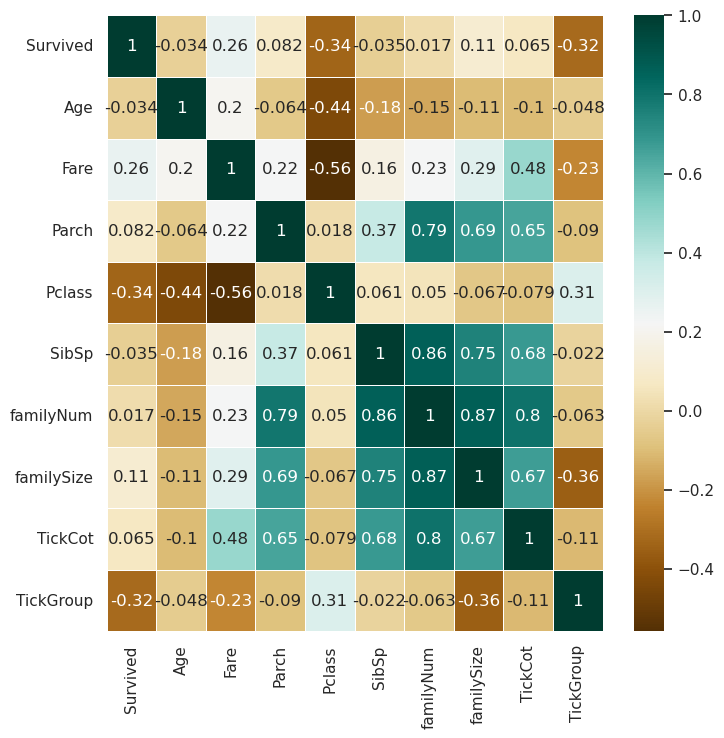

In [119]:
# 通过热力图，查看Survived与其他特征间相关性大小。
# 热力图，查看Survived与其他特征间相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass',
                    'Sex','SibSp','Title','familyNum','familySize','Deck',
                     'TickCot','TickGroup']].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
# plt.xticks(rotation=45)

In [120]:
fullSel=fullSel.drop(['familyNum','SibSp','TickCot','Parch'],axis=1)
#one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full['Pclass'],prefix='Pclass')
TickGroupDf=pd.get_dummies(full['TickGroup'],prefix='TickGroup')
familySizeDf=pd.get_dummies(full['familySize'],prefix='familySize')

fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,familySizeDf],axis=1)

## Part6:构建预测模型

In [122]:
#拆分实验数据与预测数据
experData=fullSel[fullSel['Survived'].notnull()]
preData=fullSel[fullSel['Survived'].isnull()]

experData_X=experData.drop('Survived',axis=1)
experData_y=experData['Survived']
preData_X=preData.drop('Survived',axis=1)

In [123]:
#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

#### 比较各种算法结果，进一步选择模型

In [124]:
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [125]:
# 求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})
cvResDf

,cv_mean,cv_std,algorithm
0,0.676854,0.045777,SVC
1,0.777865,0.054741,DecisionTreeCla
2,0.819338,0.045463,RandomForestCla
3,0.803620,0.038504,ExtraTreesCla
4,0.832821,0.047565,GradientBoostingCla
5,0.740787,0.028122,KNN
6,0.833933,0.034146,LR
7,0.828327,0.032677,LinearDiscrimiAna


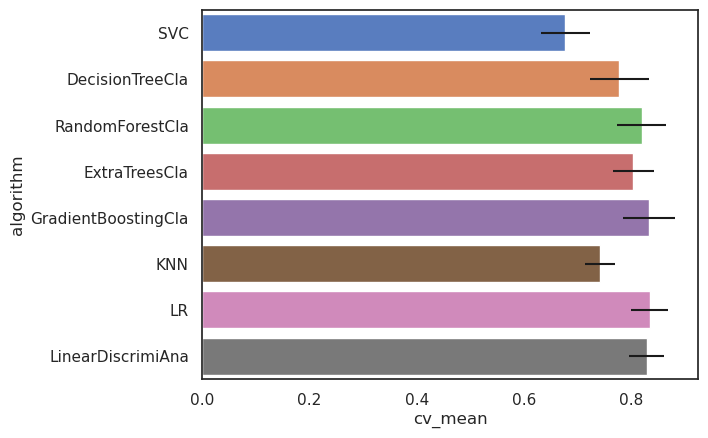

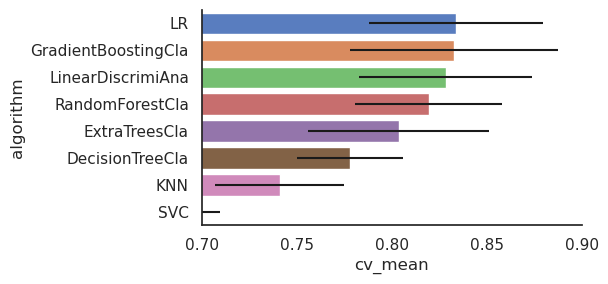

In [126]:
# 可视化查看不同算法的表现情况
sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

cvResFacet=sns.FacetGrid(cvResDf.sort_values(by='cv_mean',ascending=False),sharex=False,
            sharey=False,aspect=2)
cvResFacet.map(sns.barplot,'cv_mean','algorithm',**{'xerr':cv_std},
               palette='muted')
cvResFacet.set(xlim=(0.7,0.9))
cvResFacet.add_legend()

#### 确定选取LR和GradientBoostingCla模型

In [127]:
#GradientBoostingClassifier模型
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(experData_X,experData_y)

#LogisticRegression模型
modelLR=LogisticRegression()
LR_param_grid = {'C' : [1,2,3],
                'penalty':['l1','l2']}
modelgsLR = GridSearchCV(modelLR,param_grid = LR_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsLR.fit(experData_X,experData_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 2, 3], 'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

#### 查看模型准确度

In [128]:
#modelgsGBC模型
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)
#modelgsLR模型
print('modelgsLR模型得分为：%.3f'%modelgsLR.best_score_)
# GBC模型得分（即模型准确性）更高，继续比较其他指标的差异。

modelgsGBC模型得分为：0.843
modelgsLR模型得分为：0.834


#### 查看模型ROC曲线

<Figure size 640x480 with 0 Axes>

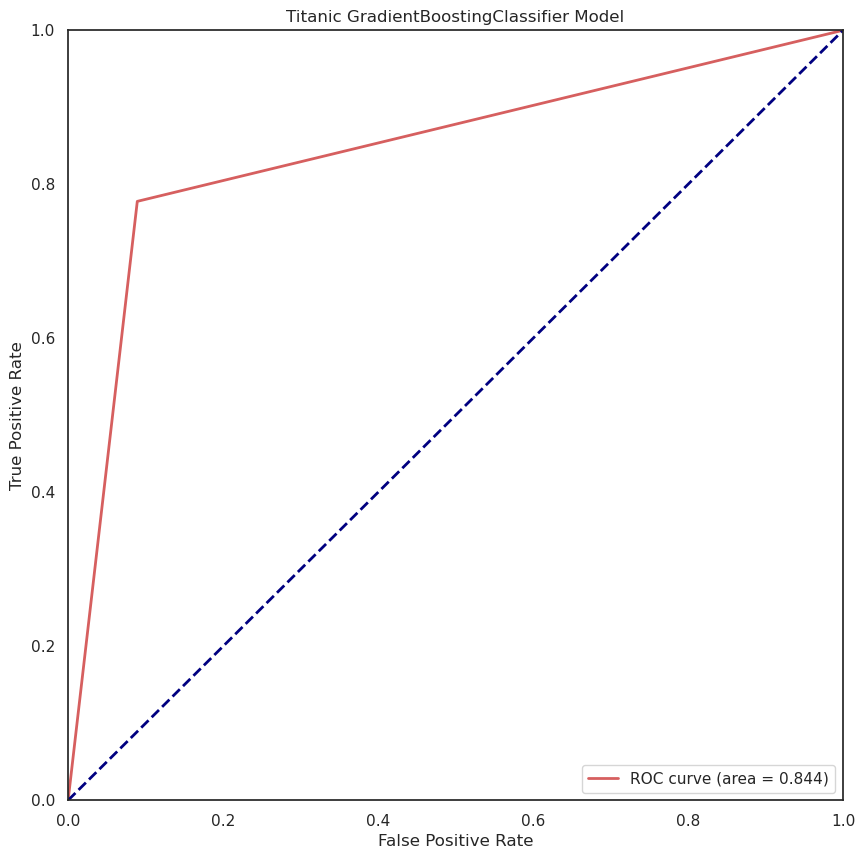

In [129]:
#求出测试数据模型的预测值
modelgsGBCtestpre_y=modelgsGBC.predict(experData_X).astype(int)
#画图
fpr,tpr,threshold = roc_curve(experData_y, modelgsGBCtestpre_y) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic GradientBoostingClassifier Model')
plt.legend(loc="lower right")



<Figure size 640x480 with 0 Axes>

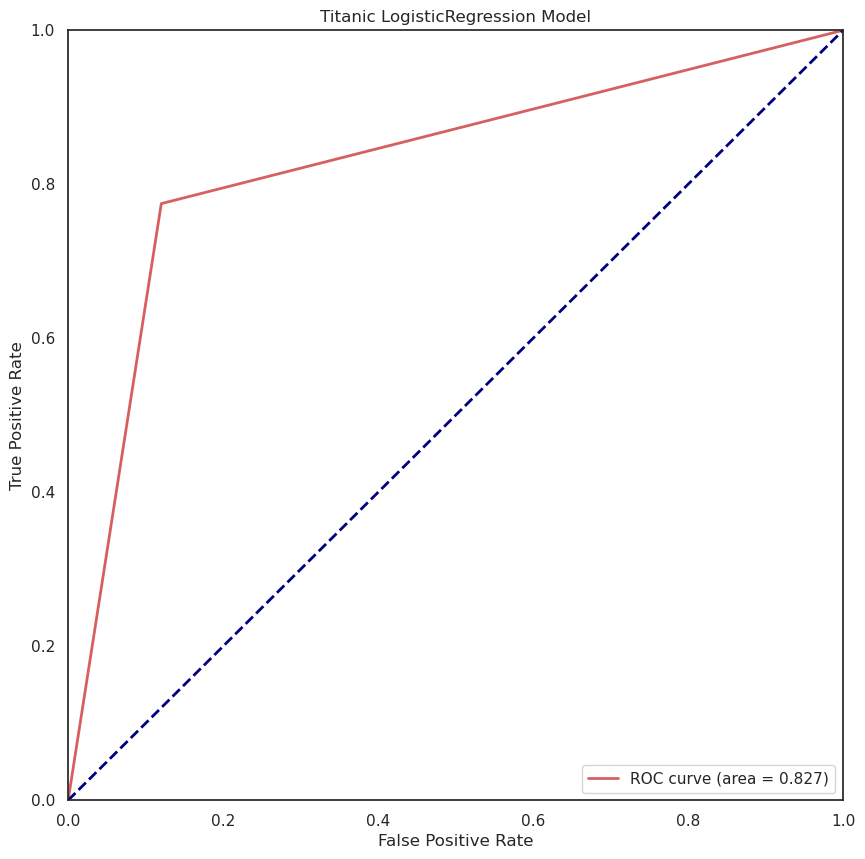

In [130]:
#求出测试数据模型的预测值
testpre_y=modelgsLR.predict(experData_X).astype(int)
#画图
fpr,tpr,threshold = roc_curve(experData_y, testpre_y) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic LogisticRegression Model')
plt.legend(loc="lower right")

#### 查看混淆矩阵

In [131]:
from sklearn.metrics import confusion_matrix
print('GradientBoostingClassifier模型混淆矩阵为\n',confusion_matrix(experData_y.astype(int).astype(str),modelgsGBCtestpre_y.astype(str)))
print('LinearRegression模型混淆矩阵为\n',confusion_matrix(experData_y.astype(int).astype(str),testpre_y.astype(str)))

GradientBoostingClassifier模型混淆矩阵为
 [[500  49]
 [ 76 266]]
LinearRegression模型混淆矩阵为
 [[483  66]
 [ 77 265]]


#### 模型预测

In [ ]:
#TitanicGBSmodle
GBCpreData_y=modelgsGBC.predict(preData_X)
GBCpreData_y=GBCpreData_y.astype(int)
#导出预测结果
GBCpreResultDf=pd.DataFrame()
GBCpreResultDf['PassengerId']=full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived']=GBCpreData_y
GBCpreResultDf
#将预测结果导出为csv文件
GBCpreResultDf.to_csv('gender_submission_frommyself.csv',index=False)